In [31]:
# importing packages
%matplotlib inline

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
from plotnine import ggplot ,aes , geom_line
from wordcloud import WordCloud , STOPWORDS
from scipy.spatial.distance import cdist , pdist
from sklearn.cluster import KMeans , SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score
rcParams['figure.figsize'] = 15,5
from tabulate import tabulate
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# reading dataset
data = pd.read_csv('[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data[['title' , 'groups' , 'keywords' , 'topics']] 
# author(not required) and abstract(extremely detailed) column was removed.

In [3]:
print(len(data_train))
data_train.head()

398


,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...


In [4]:
# Stretching the Data Frame Row-wise as a Function of Groups

s = data_train['groups'].str.split('\n').apply(pd.Series , 1).stack()

s.index = s.index.droplevel(-1) # default 
# Level(s) to stack from the column axis onto the index axis,defined as one index or label, or a list of indices or labels.

s.name = 'groups'
del data_train['groups']

data_train = data_train.join(s).reset_index()

In [5]:
# Adding New Variable for Group Membership
data_train['flags'] = pd.Series(np.ones(len(data_train)) , index = data_train.index)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


In [6]:
# Adding a function for matrix creation

def matrix_from_dataframe(data_train) :
    matrix = data_train.pivot_table(index = ['title'] , columns = ['groups'] , values = 'flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix , x_cols

In [7]:
matrix , x_cols = matrix_from_dataframe(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
matrix

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,Wormhole Hamiltonian Monte Carlo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
392,Worst-Case Solution Quality Analysis When Not ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393,Zero Pronoun Resolution as Ranking,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
394,k-CoRating: Filling up Data to Obtain Privacy ...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Elbow Method for determining number of Clusters

Text(0.5, 1.0, 'Elbow for KMeans clustering')

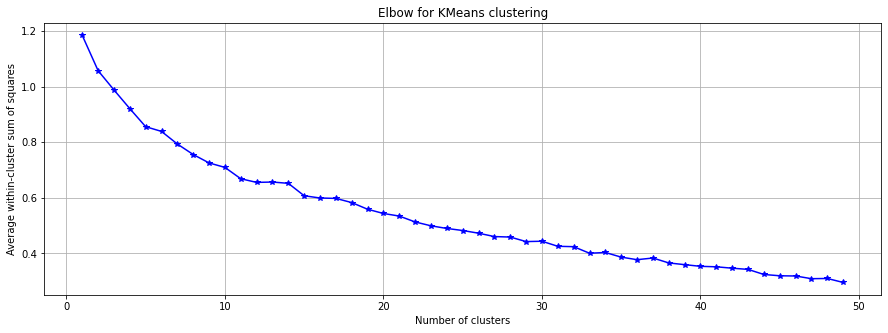

In [9]:
matrix , x_cols = matrix_from_dataframe(data_train)
X = matrix[x_cols]

K = range(1,50)

# number of clusters
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM] # centroids

# distance between centroids
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k] # distance

avgWithinSS = [sum(d)/X.shape[0] for d in dist] # Average within cluster Sum of squares

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K , avgWithinSS , 'b*-' ) # marks points with stars
plt.grid(True)

# labeling
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

As we may observe that the average within-cluster sum of squares has not decreased significantly thereby making an elbow where k = 9, such that we may infer that the number of clusters is 9.But,still there is more statistics analysis that we can perform to be sure about the number of clusters. 

### F-test for confirming the number of Clusters

Text(0.5, 1.0, 'Elbow for KMeans clustering')

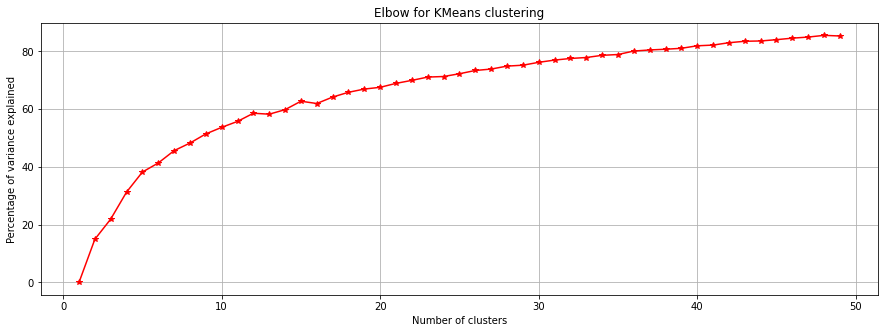

In [10]:
# applying elbow method and variance explained to data matrix
matrix, x_cols = matrix_from_dataframe(data_train)
X = matrix[x_cols]

K = range(1,50)

KM = [KMeans(n_clusters = k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]

# Variance explained
wcss = [sum(d**2) for d in dist] # within cluster sum of squares
tss = sum(pdist(X)**2)/X.shape[0] # total sum of squares
bss = tss-wcss # between sum of squares

# plotting
fig = plt.figure()
ax = fig.add_subplot(111)

# percentage of variance explained // F-test
ax.plot(K, bss/tss*100, 'r*-')

plt.grid(True)

# labeling
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

As the graph is increasing smoothly so it is difficuilt to determine the elbow but as we observe the graph very carefully,we may observe that a gradient is observed at K=9 , we may considerr this to be elbow such that number of clusters is 9.

### Silhouette Score :
#### used to measure how the observations within cluster are close enough or how different(far) the clusters are from each other

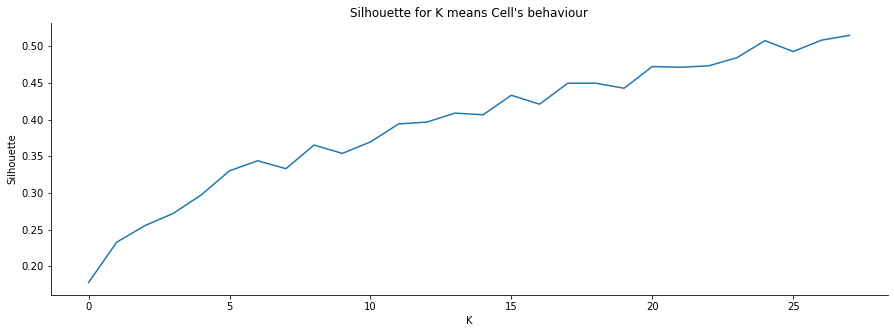

In [11]:
# Plotting Silhouette Score Plot from the Data Matrix

s = []

for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    s.append(silhouette_score(X , labels , metric = 'euclidean'))

plt.plot(s)
plt.ylabel("Silhouette")
plt.xlabel("K")
plt.title("Silhouette for K means Cell's behaviour")
sns.despine()

Since the silhouette coefficient is highest where the number of clusters is 27 , theoritically it suggests that the optimal number of cluster for the dataset is where the silhouette coefficient is highest.Practically,this is impossible for the present scinerio 27 clusters are pretty large number for a 398 observation dataset.

Therefore , for my present analysis, will consider 9 as the optimal number of clusters based on variance explanation and Elbow method

In [12]:
# Training K Means model with cluster size as 9
matrix,x_cols = matrix_from_dataframe(data_train)
X = matrix[x_cols]

print("Cluster Number Vs Number of Research papers(cluster involves)")
cluster = KMeans(n_clusters = 9 ,random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

Cluster Number Vs Number of Research papers(cluster involves)


3    88
0    68
7    53
2    48
4    42
5    32
1    29
6    19
8    17
Name: cluster, dtype: int64

### PCA : Principal Component Analysis

In [13]:
# Using PCA to transform group related features into two components
pca = PCA(n_components = 2)

matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['title','cluster','x','y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",2,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,7,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",6,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,7,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,5,0.198578,-0.129668


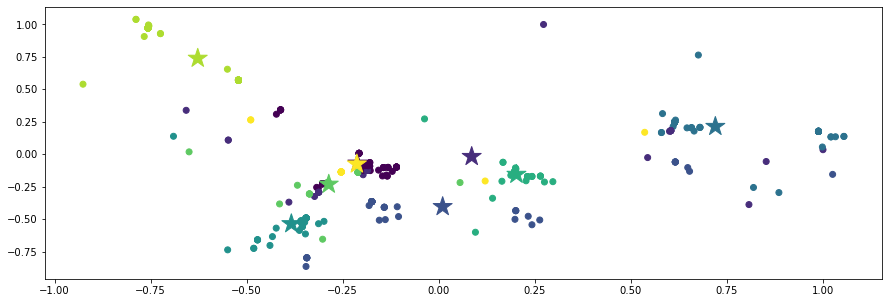

In [33]:
# plotting clusters in two-dimensional space
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers,columns = ['x','y'])
cluster_centers['cluster'] = range(0,len(cluster_centers))

plt.scatter(customer_clusters['x'],customer_clusters['y'],c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'],cluster_centers['y'],c=cluster_centers['cluster'],marker = '*',s=400) # * shows the cluster centeroids
plt.show()

In [15]:
# Merging Matrix into original Data frame
customer_clusters.columns.name = None
dataframe = data_train.merge(customer_clusters , on = 'title')
dataframe.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,3,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,2,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,2,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,7,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


In [16]:
# function for generating wordcloud
def wordcloud_object(word_string):
    FONT_ROOT = './fonts/'    
    wordcloud = WordCloud(font_path=FONT_ROOT + 'arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

# creating function to plot wordcloud for each cluster
def plot_wordcloud(df,clusters,pivot):
    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List_ = []
        
        for x in dataframe[dataframe['cluster'] == cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass
            
        if List_:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster : %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

Wordcloud for each cluster generated from keywords


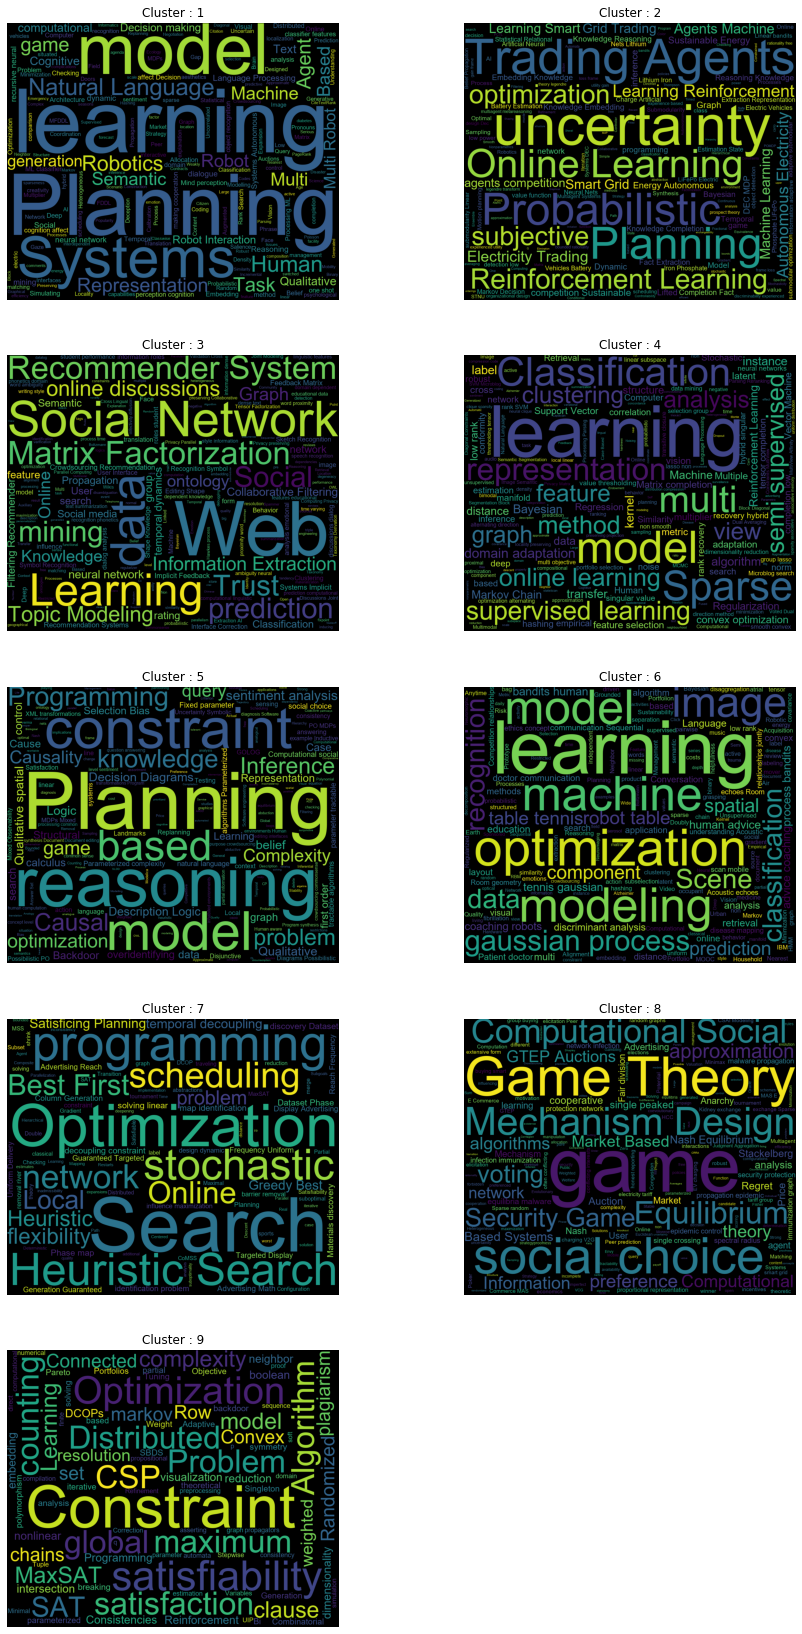

In [17]:
print("Wordcloud for each cluster generated from keywords")
plot_wordcloud(dataframe,cluster.n_clusters,'keywords')

In [18]:
# tabulate the keywords having maximum frequency with respect to each cluster
print("Table 1 : Depicting most frequent keywords with respect to each cluster")
d = [['1','Planning , Model, Learning, Systems'],['2','Probabilistic,Trading Agents,Unccertainity,Online'],['3','Data, Web, Recommender System, Social Network'],['4','Classification, Sparse, representation, supervised learning'],['5','Programming, Constraint, reasoning, based knowledge'],['6','Optimization,learning,machine,image'],['7','programming, heuristic, scheduling, stochastic'],['8','game,theory,social choice,computational'],['9','constraint,CSP,satisfiability,distributed']]
print(tabulate(d ,headers=['Cluster','Most frequent keywords(top 4)']))

Table 1 : Depicting most frequent keywords with respect to each cluster
  Cluster  Most frequent keywords(top 4)
---------  -----------------------------------------------------------
        1  Planning , Model, Learning, Systems
        2  Probabilistic,Trading Agents,Unccertainity,Online
        3  Data, Web, Recommender System, Social Network
        4  Classification, Sparse, representation, supervised learning
        5  Programming, Constraint, reasoning, based knowledge
        6  Optimization,learning,machine,image
        7  programming, heuristic, scheduling, stochastic
        8  game,theory,social choice,computational
        9  constraint,CSP,satisfiability,distributed


Wordcloud for each cluster generated from groups


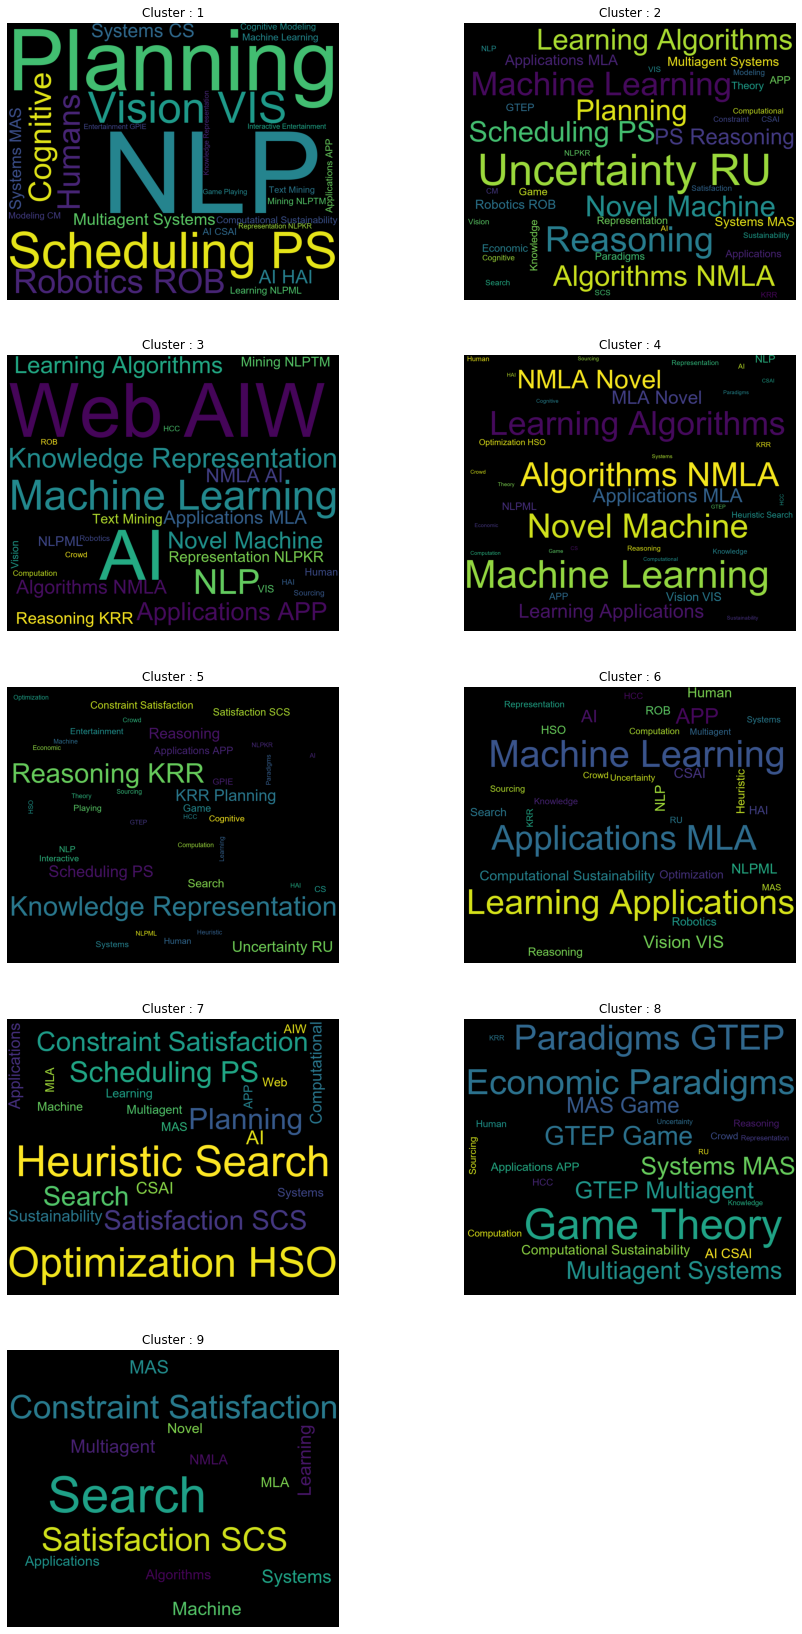

In [19]:
print("Wordcloud for each cluster generated from groups")
plot_wordcloud(dataframe,cluster.n_clusters,'groups')

Wordcloud for each cluster generated from topics


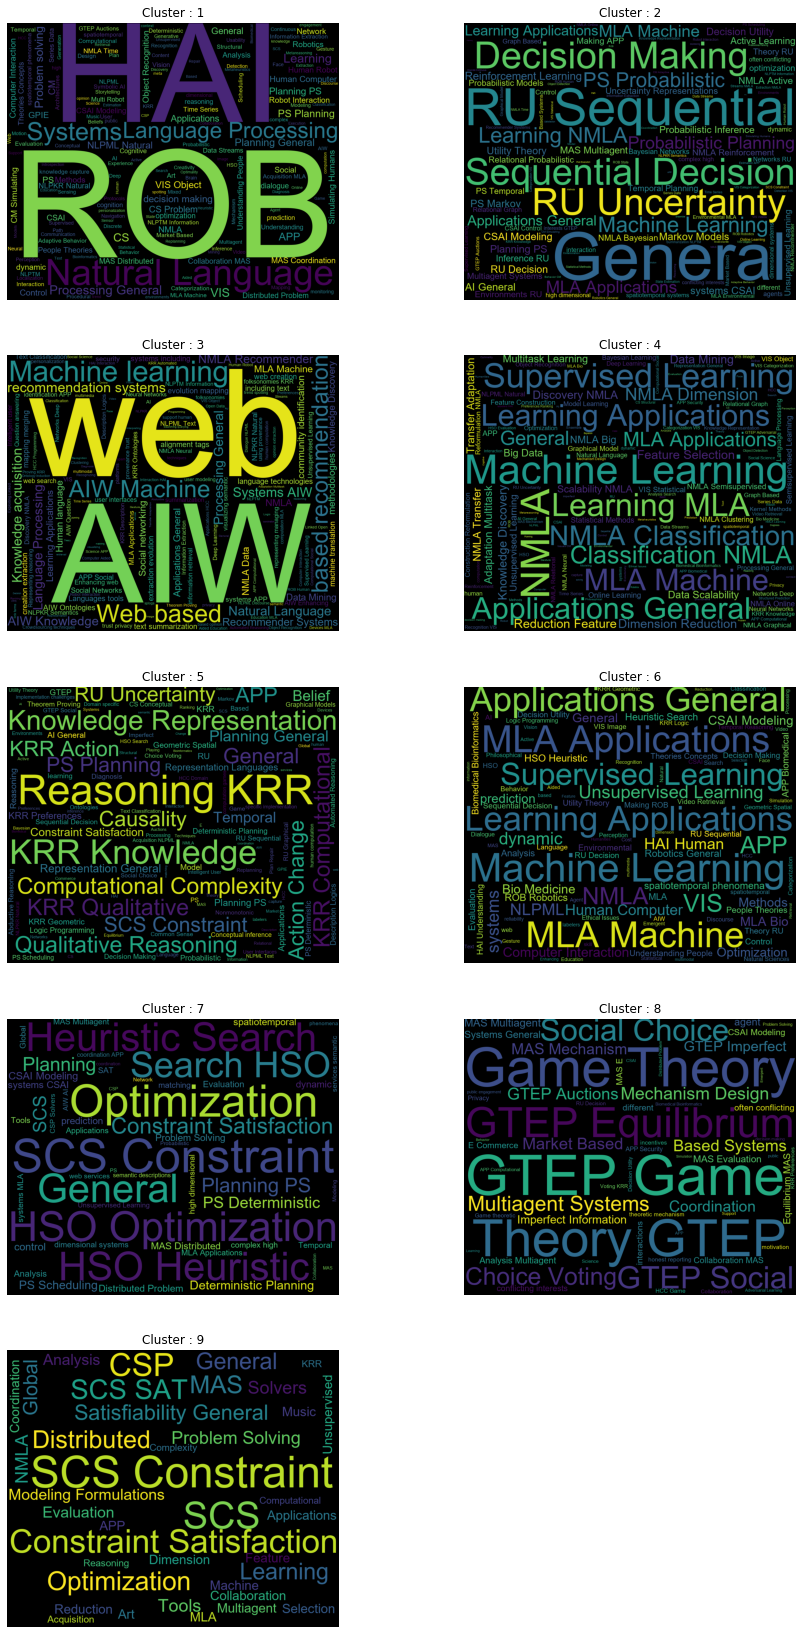

In [20]:
print("Wordcloud for each cluster generated from topics")
plot_wordcloud(dataframe,cluster.n_clusters,'topics')

Considering all the wordclouds,we may come up with the most frequently used words or segments as listed in Table 1 in all the sections of the papers whether keywords or topics or groups, such that the unique terms could be considered for marketing in the subsequent next conferences.